# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [38]:
import os
import sys
import random
import math
import re
import time
import json
import datetime
import skimage.draw
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("D:\keras\Matterpot_Mask_RCNN_Balloon")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

from samples.construction import site

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#CRACK_WEIGHTS_PATH = "mask_rcnn_crack_0011.h5"  # TODO: update this path

## Configurations

In [39]:
config = site.SiteConfig()
Site_DIR = os.path.join(ROOT_DIR, "NewSet")

In [40]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [41]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [42]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [43]:
# Load validation dataset
dataset = site.SiteDataset()
dataset.load_Site(Site_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 194
Classes: ['BG', 'scaffold', 'safescaffold', 'person']


## Load Model

In [44]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [45]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = "D:\keras\Matterpot_Mask_RCNN_Balloon\logs\site20191018T2046\mask_rcnn_site_0247.h5"

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\keras\Matterpot_Mask_RCNN_Balloon\logs\site20191018T2046\mask_rcnn_site_0247.h5
Re-starting from epoch 247


## Run Detection

image ID: site.37.jpg (36) D:\keras\Matterpot_Mask_RCNN_Balloon\NewSet\val\37.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (2,)                  min:    0.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:    5.00000  max:  511.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


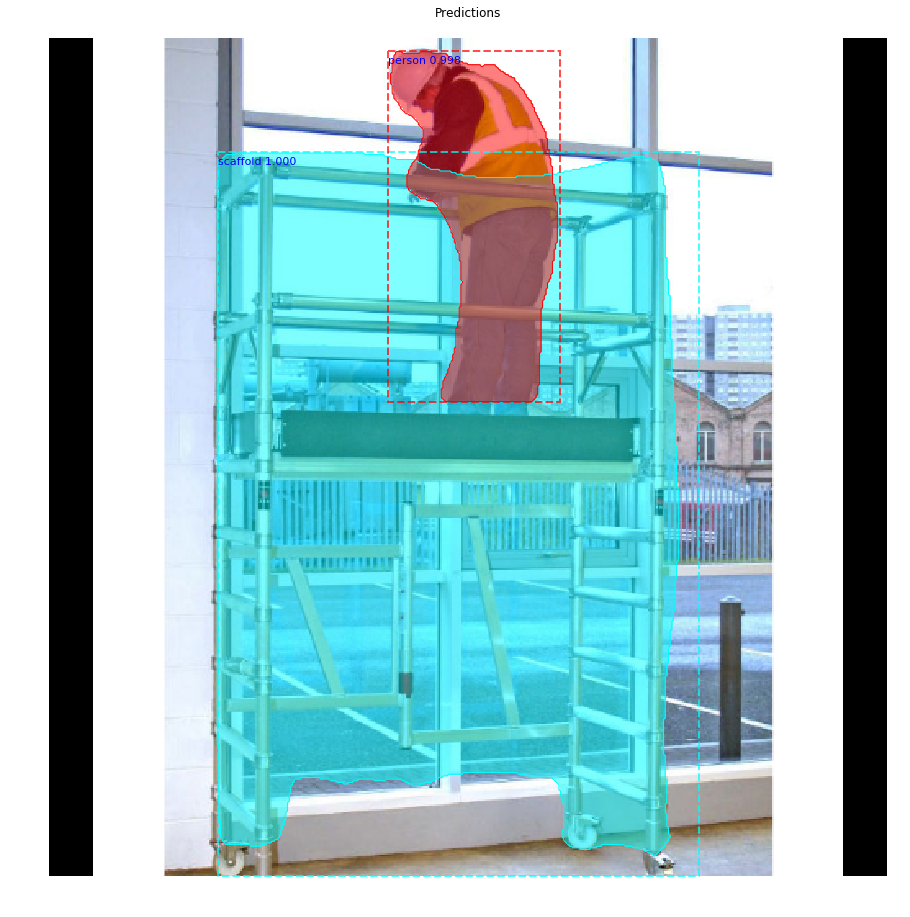

In [46]:
image_id = 36
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [53]:
def get_site_boxes(boxes, class_ids):
    site_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [2]:
            site_boxes.append(box)

    return np.array(site_boxes),np.array(site_boxes).tolist()

def get_person_boxes(boxes, class_ids):
    person_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3]:
            person_boxes.append(box)

    return np.array(person_boxes),np.array(person_boxes).tolist()

#def get_mask_coordinates(masks):
#    person_mask = []
#    scaffold_mask = []
    
#    for mask in enumerate(masks):
#        print(mask)
#        cat = r['class_ids']
        #if cat[mask] == 3:
            #person_mask.append(mask)
       # else:
        #    scaffold_mask.append(mask)
#    return person_mask, scaffold_mask
        

In [54]:
# Filter the results to only grab the car / truck bounding boxes
site_boxes, site_coord = get_site_boxes(r['rois'], r['class_ids'])
person_boxes, person_coord = get_person_boxes(r['rois'], r['class_ids'])
#person_mask, scaffold_mask = get_mask_coordinates(r['masks'])

#extract = utils.extract_bboxes(person_mask)
print(site_boxes)
print(person_boxes)
#overlaps = utils.compute_overlaps(site_boxes,person_boxes)
#print(overlaps)

[[ 43  51 509 446]]
[[ 25 239 102 287]
 [125 254 209 293]
 [210 282 328 321]]


In [55]:
for s in enumerate(site_coord):
    site_x = s[1]
    break

for r in enumerate(person_coord):
    person_x = r[1]
    
    l2_x=person_x[0]
    l2_y=person_x[1]
    r2_x=person_x[2]
    r2_y=person_x[3]


    l1_x=site_x[0]
    l1_y=site_x[1]
    r1_x=site_x[2]
    r1_y=site_x[3]

In [56]:
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
        
l1 = Point(l1_x,l1_y) 
r1 = Point(r1_x,r1_y) 
l2 = Point(l2_x,l2_y) 
r2 = Point(r2_x,r2_y)


In [57]:
def doOverlap(l1, r1, l2, r2): 
      
    Scen_x = (l1_y+r1_y)/2
    Scen_y = (l1_x+r1_x)/2
    
    #print(Scen_x)
    #print(Scen_y)
    
    Percen_x = (l2_y+r2_y)/2
    Percen_y = (l2_x+r2_x)/2
    
    #print(Percen_x)
    #print(Percen_y)

    #if(r2_x < Scen_x):
    if(Percen_y < Scen_x):
        print("True")
        if(r2.y < r1.y or l2.y > l1.y):
            print("Fully Overlap")
            #return True
        else:
            print("Partially Overlap")
            #return False
    else:
        print("No Overlap")
        #return False

In [58]:
for s in enumerate(site_coord):
    site_x = s[1]
    break

for r in enumerate(person_coord):
    person_x = r[1]
    
    l2_x=person_x[0]
    l2_y=person_x[1]
    r2_x=person_x[2]
    r2_y=person_x[3]


    l1_x=site_x[0]
    l1_y=site_x[1]
    r1_x=site_x[2]
    r1_y=site_x[3]
    #print(l1_x,l1_y,r1_x,r1_y)
    #print(l2_x,l2_y,r2_x,r2_y)

    print(person_x)
    print(site_x)
    
    doOverlap(l1, r1, l2, r2)


[25, 239, 102, 287]
[43, 51, 509, 446]
True
Fully Overlap
[125, 254, 209, 293]
[43, 51, 509, 446]
True
Fully Overlap
[210, 282, 328, 321]
[43, 51, 509, 446]
No Overlap


In [47]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 195
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [600 800   3]   AP: 0.13
  1 [500 800   3]   AP: 0.45
  2 [500 375   3]   AP: 0.60
  3 [1080 1920    3]   AP: 0.12
  4 [900 765   3]   AP: 0.80
  5 [500 375   3]   AP: 0.60
  6 [465 316   3]   AP: 0.33
  7 [158 319   3]   AP: 0.40
  8 [500 375   3]   AP: 0.50
  9 [592 889   3]   AP: 0.07
 10 [168 299   3]   AP: 0.55
 11 [500 375   3]   AP: 0.10
 12 [1116 1674    3]   AP: 0.47
 13 [480 852   3]   AP: 0.25
 14 [166 250   3]   AP: 0.70
 15 [292 400   3]   AP: 0.52
 16 [184 273   3]   AP: 0.10
 17 [1000 1000    3]   AP: 0.33
 18 [251 300   3]   AP: 0.62
 19 [190 265   3]   AP: 0.80
 20 [1106  736    3]   AP: 0.35
 21 [332 496   3]   AP: 0.38
 22 [190 265   3]   AP: 0.40
 23 [399 531   3]   AP: 0.12
 24 [800 800   3]   AP: 0.80
 25 [183 275   3]   AP: 0.80
 26 [843 736   3]   AP: 0.65
 27 [601 922   3]   AP: 0.85
 28 [256 197   3]   AP: 0.80
 29 [1024  685    3]   AP: 0.70
 30 [448 600   3]   AP: 0.59
 31 [142 356   3]   AP: 0.13
 32 [1541 1024    3]   AP: 0.70
 33 [183 275   3]   AP: 0

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

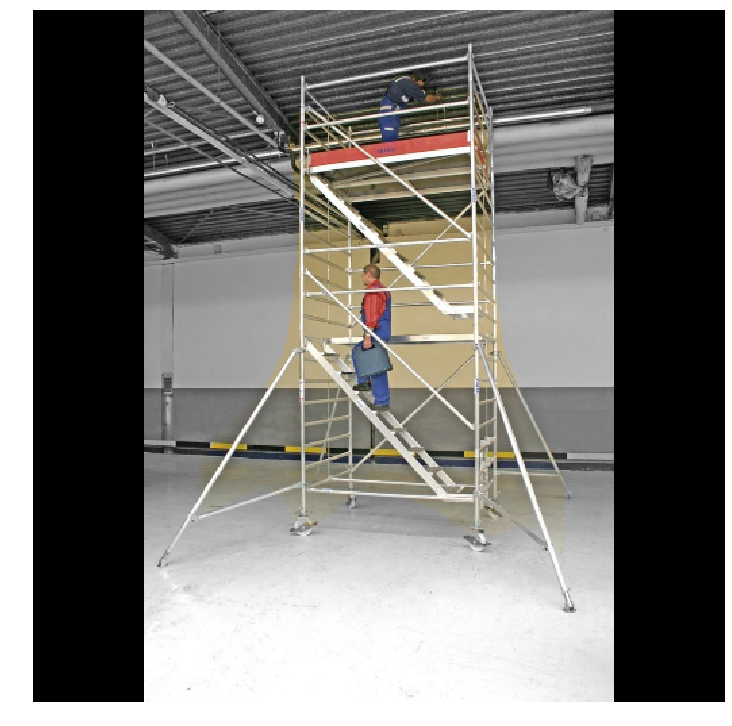

In [69]:
splash = site.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [12]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.72128  max:    3.26172  float64
positive_anchors         shape: (13, 4)               min:   18.74517  max:  506.50967  float64
negative_anchors         shape: (243, 4)              min: -181.01934  max:  549.25483  float64
neutral anchors          shape: (65216, 4)            min: -362.03867  max:  810.03867  float64
refined_anchors          shape: (13, 4)               min:   40.00000  max:  511.00000  float32


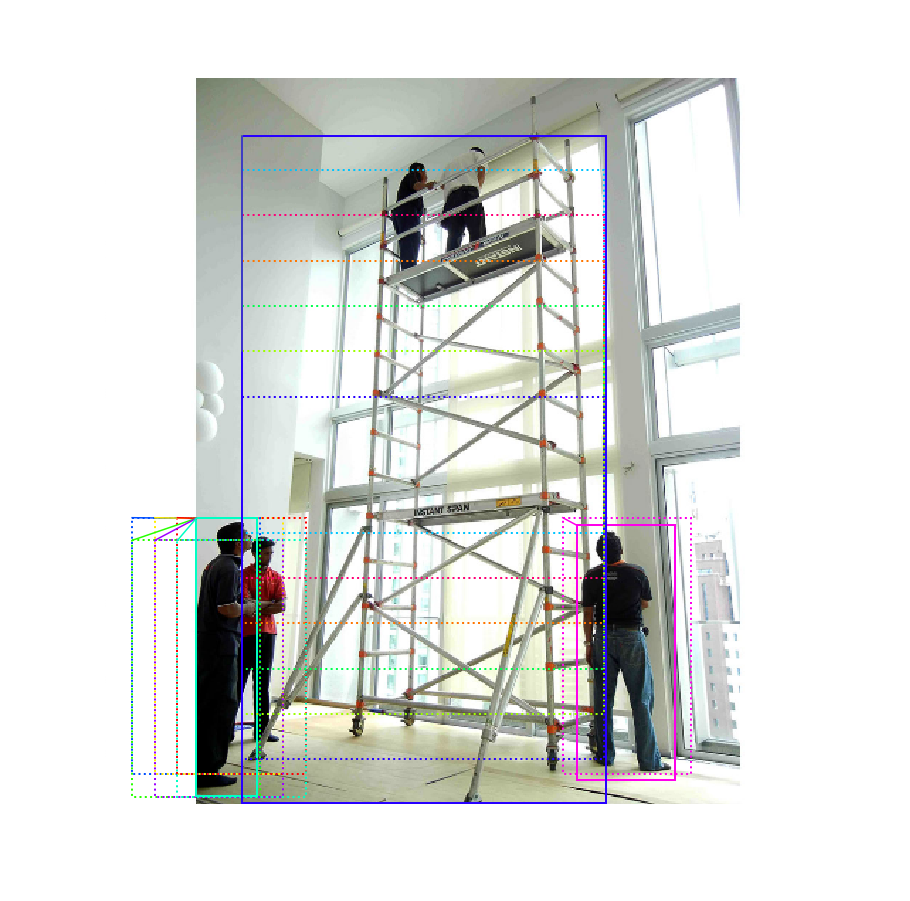

In [13]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [14]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.70849  max:    1.58325  float32
refined_anchors          shape: (1, 6000, 4)          min: -1167.42676  max: 1168.59326  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (307,)                min:    0.00000  max: 5809.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


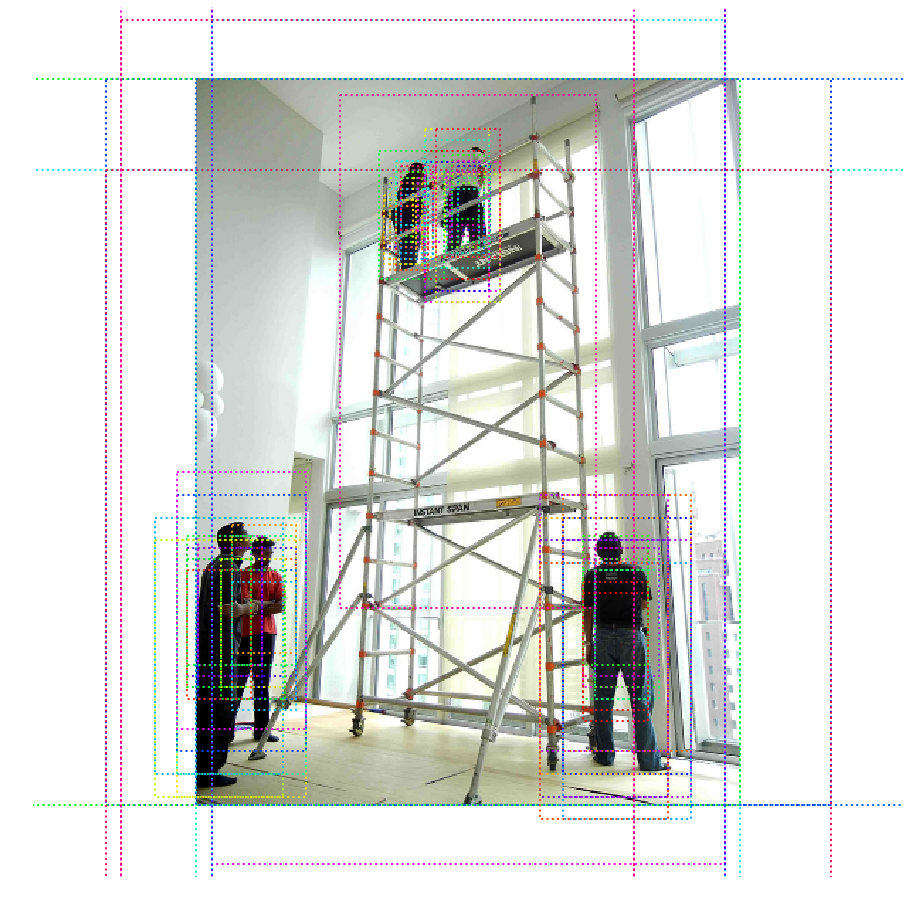

In [15]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

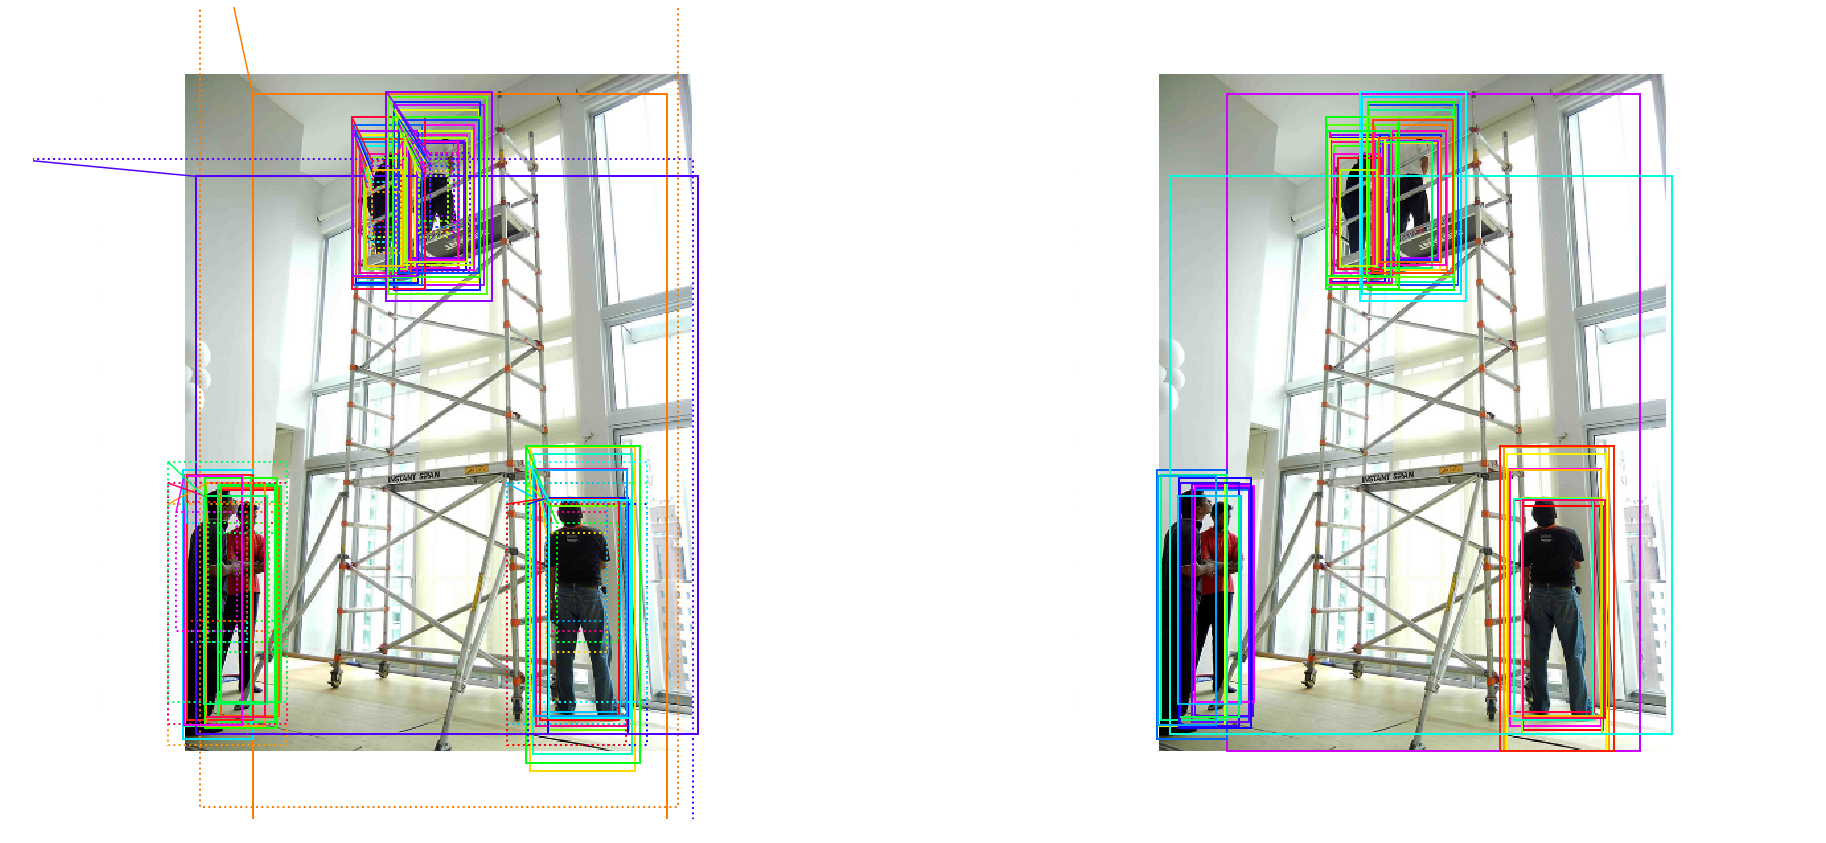

In [16]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

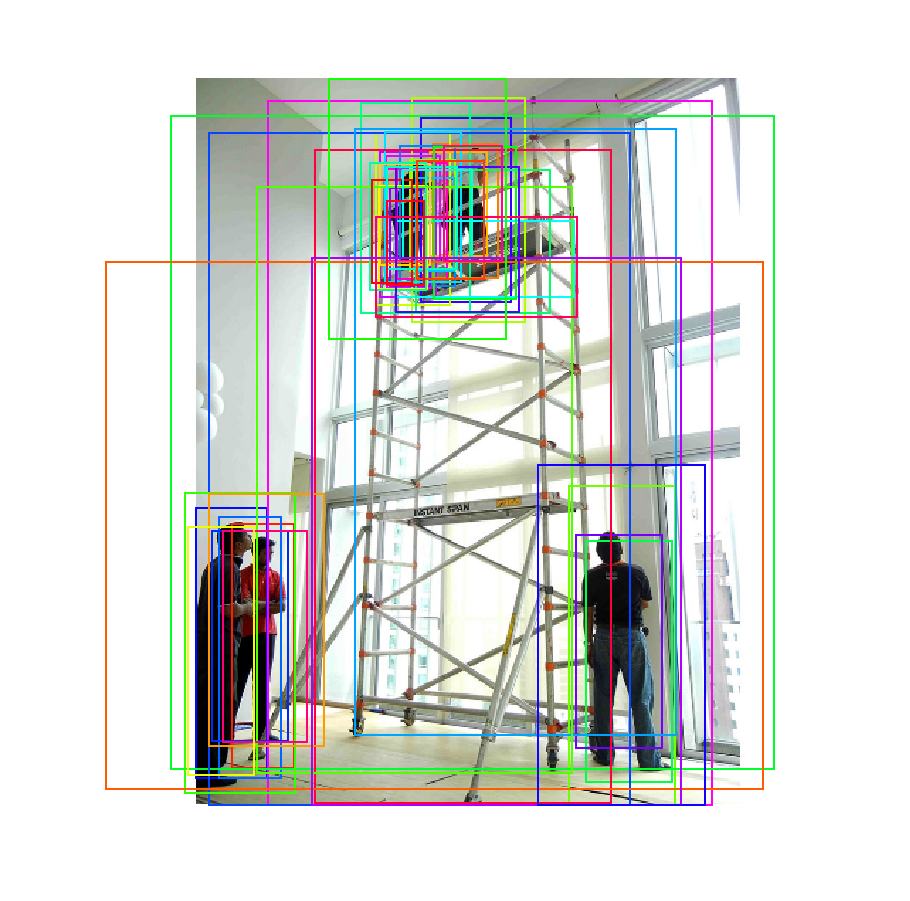

In [17]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

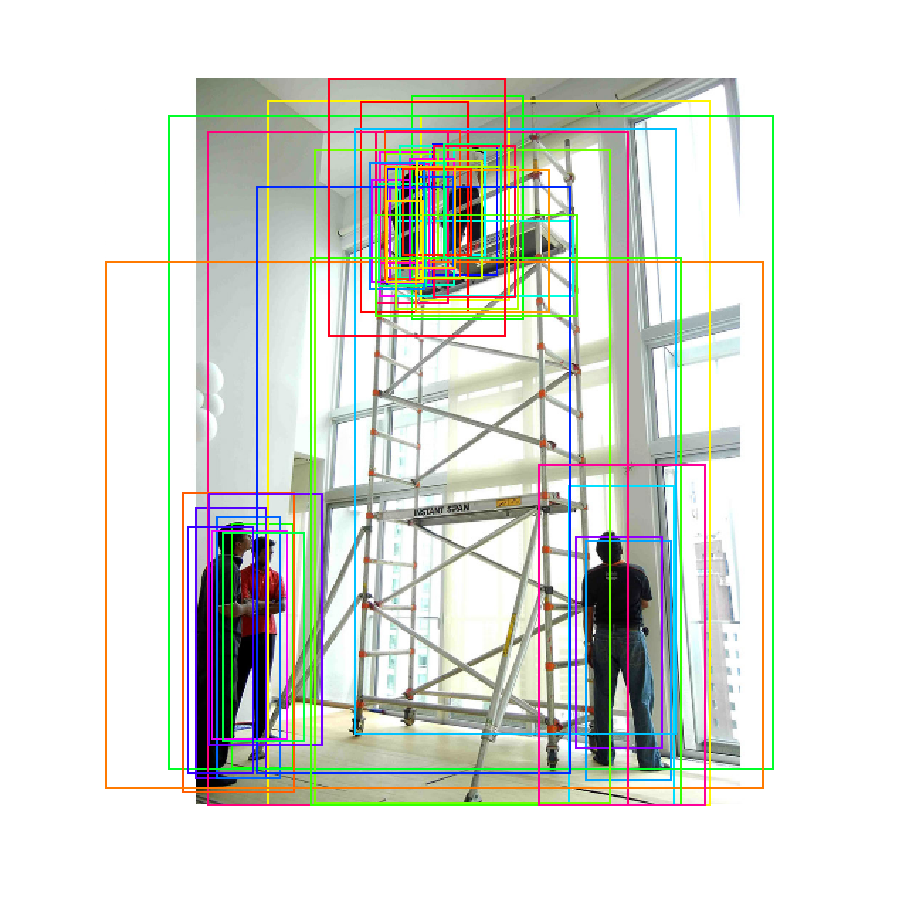

In [18]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [19]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 4, 4)       min:   -4.28995  max:    4.61852  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00001  max:    0.99999  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    3.00000  float32


6 detections: ['person' 'person' 'person' 'safescaffold' 'person' 'person']


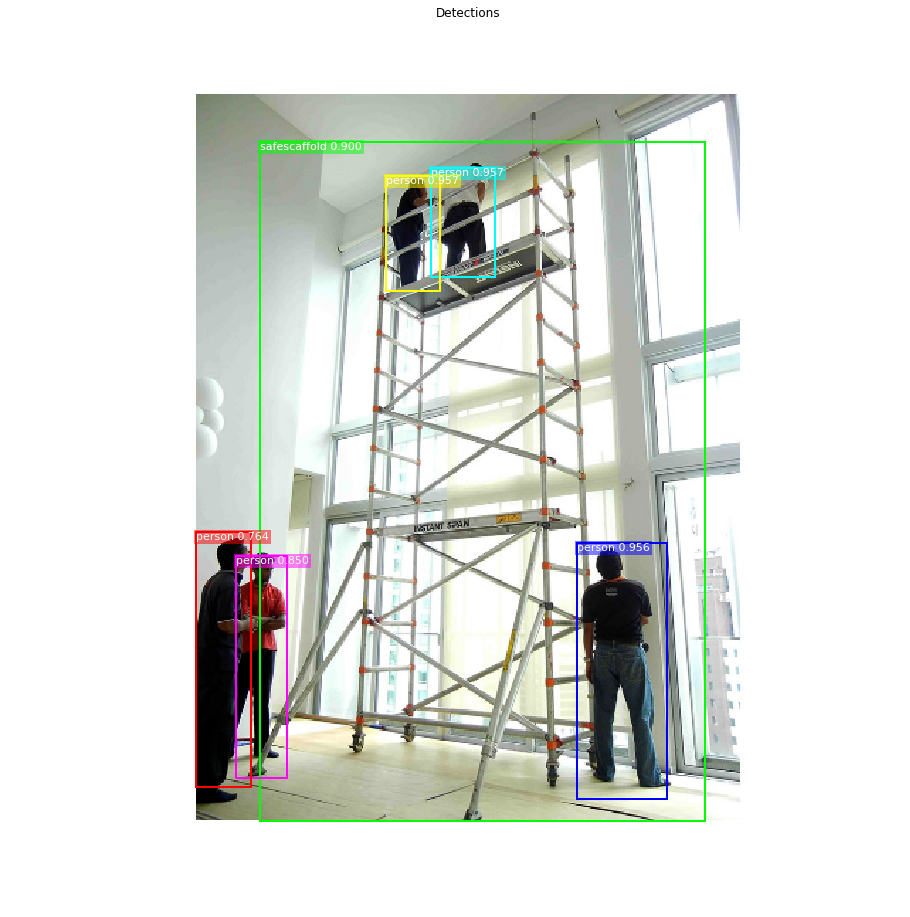

In [20]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [21]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

307 Valid proposals out of 1000
66 Positive ROIs
[('BG', 934), ('person', 48), ('safescaffold', 18)]


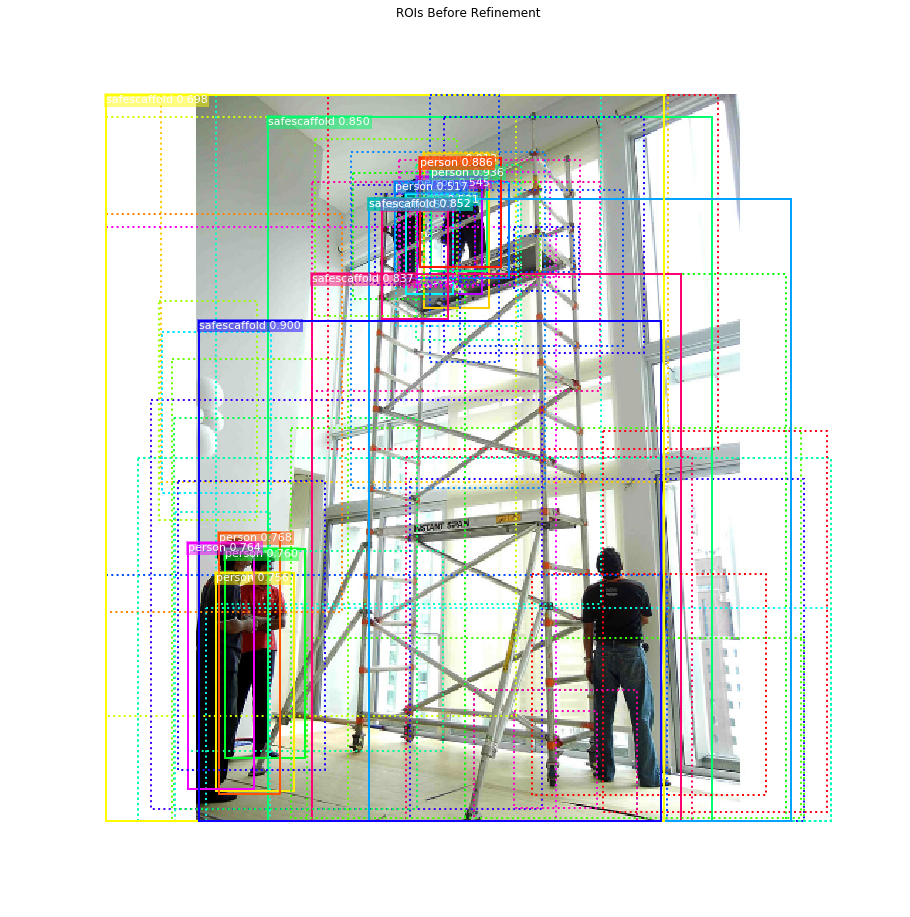

In [22]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.20083  max:    2.76581  float32
refined_proposals        shape: (1000, 4)             min: -114.00000  max:  537.00000  int32


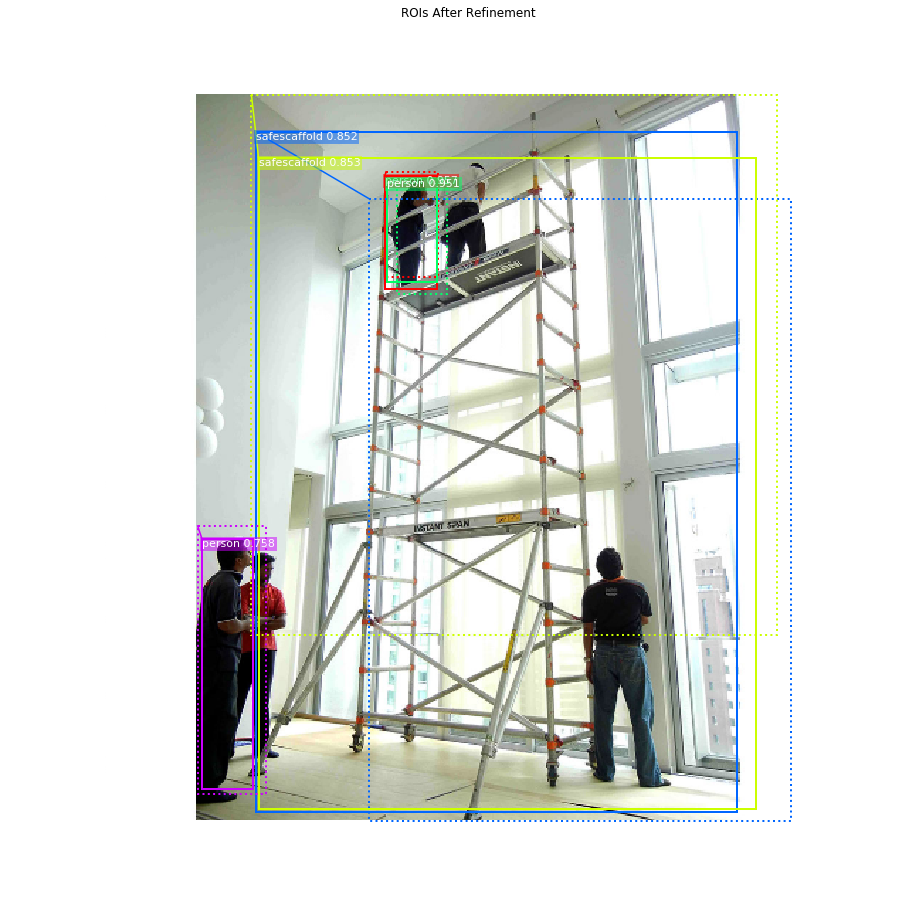

In [23]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [24]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 66 detections:
[  0   2   3   4   5   6   7   8   9  11  12  13  14  15  17  18  20  21
  22  23  25  26  27  30  33  34  35  36  37  42  43  44  46  47  48  51
  53  55  59  61  67  69  70  71  73  76  77  82  88  90  91  94  98 111
 118 122 133 135 153 162 166 168 174 189 263 290]


In [25]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 64:
[  0   2   3   4   5   6   7   8   9  11  12  13  14  15  17  18  20  21
  22  23  25  26  27  30  33  34  35  36  37  42  43  44  46  47  48  51
  53  55  59  61  67  69  70  71  73  76  77  82  88  90  91  94  98 118
 122 133 135 153 166 168 174 189 263 290]


#### Per-Class Non-Max Suppression

In [26]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

safescaffold          : [  7  13  18  25  26  30  36  44  61  69  77  82  94 122 168 174 263 290] -> [94]
person                : [  0   2   3   4   5   6   8   9  11  12  14  15  17  20  21  22  23  27
  33  34  35  37  42  43  46  47  48  51  53  55  59  67  70  71  73  76
  88  90  91  98 118 133 135 153 166 189] -> [47 21 12  0 46]

Kept after per-class NMS: 6
[ 0 12 21 46 47 94]


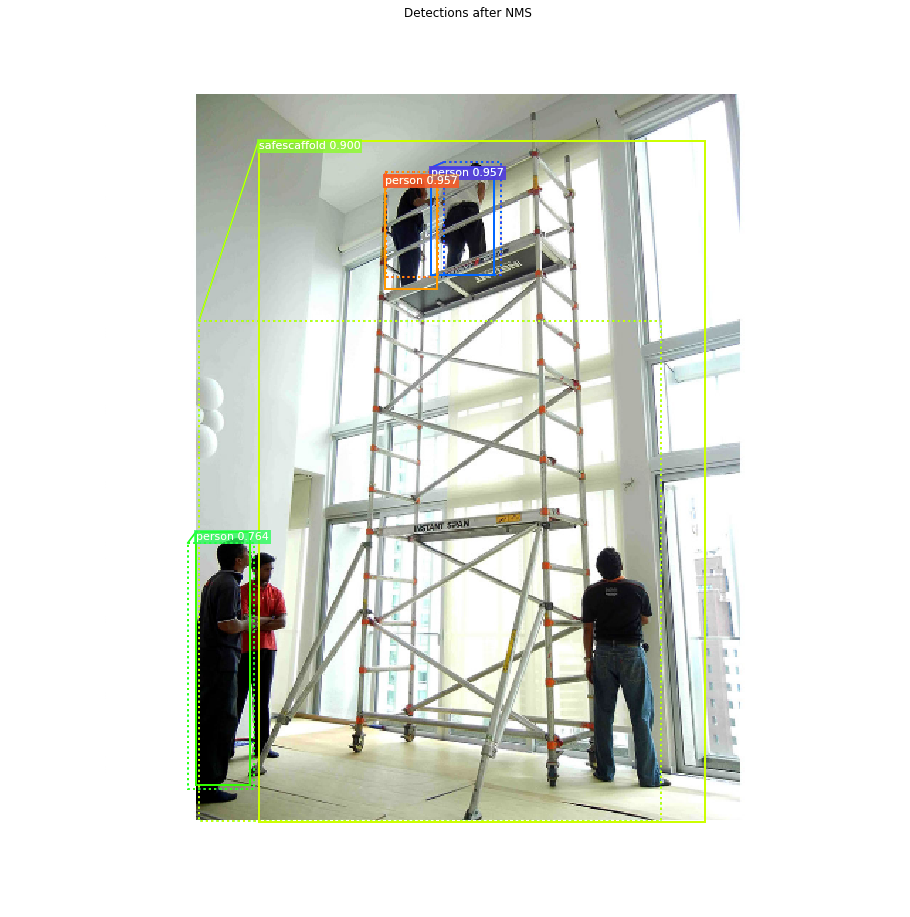

In [27]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

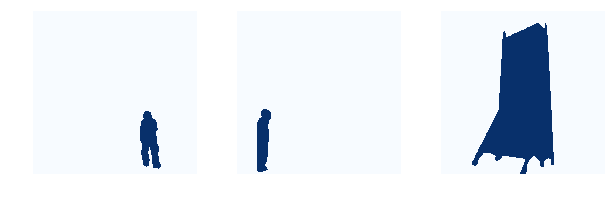

In [28]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [29]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    3.00000  float32
masks                    shape: (1, 100, 28, 28, 4)   min:    0.00001  max:    0.99999  float32
6 detections: ['person' 'person' 'person' 'safescaffold' 'person' 'person']


In [30]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00001  max:    0.99996  float32
det_masks                shape: (6, 512, 512)         min:    0.00000  max:    1.00000  bool


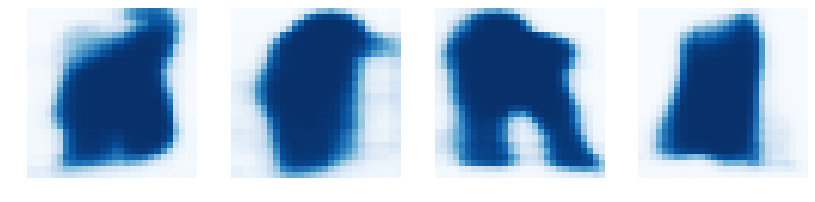

In [31]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

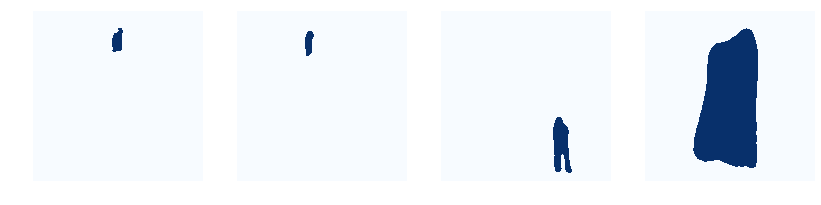

In [32]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [33]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    #("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   35.44004  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   30.86334  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -5.91041  max:  106.27114  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


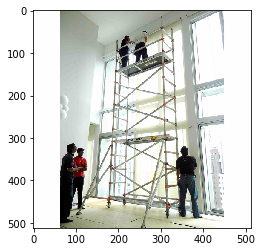

In [34]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

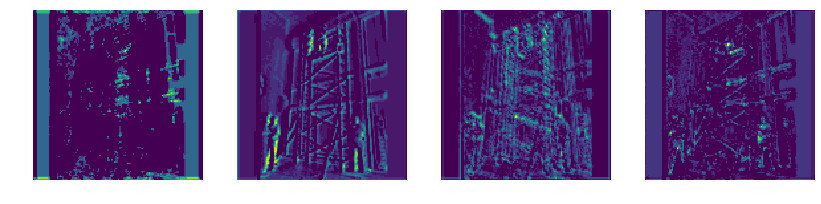

In [35]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [48]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset.image_ids[:195]
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7073302256388733


In [73]:
def get_site_boxes(boxes, class_ids):
    site_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [2]:
            site_boxes.append(box)

    return np.array(site_boxes)

def get_person_boxes(boxes, class_ids):
    person_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3]:
            person_boxes.append(box)

    return np.array(person_boxes)

In [75]:
# Filter the results to only grab the car / truck bounding boxes
site_boxes = get_site_boxes(r['rois'], r['class_ids'])
person_boxes = get_person_boxes(r['rois'], r['class_ids'])


overlaps = utils.compute_overlaps(site_boxes,person_boxes)

print(overlaps)

[[0.03777139]]
